In [64]:
import spacy
from spacy.matcher import Matcher
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd 

nlp = spacy.load('en_core_web_sm')

candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")

In [65]:
# doc = nlp("confused and frustrated, connie decides to leave on her own.")

# for tok in doc:
#     print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


In [66]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [67]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [68]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:40<00:00, 106.74it/s]


In [103]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None) 

    matches = matcher(doc, as_spans=True)
    
    return matches

In [108]:
relations = [get_relation(i) for i  in tqdm(candidate_sentences['sentence'])]

In [118]:
true_relations = [str(rel[-1]) if rel!= [] else ' ' for rel in relations]
true_relations

['decides',
 'heard in',
 'paralyzed by',
 'set on',
 'wails with',
 "'s",
 'joined',
 'revealed',
 'revealed as',
 'tried',
 'went through',
 'circling',
 'supervised',
 'features',
 'is',
 'injures',
 'tasked with',
 'attacked by',
 'kota',
 'return',
 'stand',
 'considered for',
 'served as',
 'completed on',
 'released',
 'released',
 'distributed by',
 'ended',
 'chandler',
 'dedicated to executive',
 'approach former',
 'frees',
 'disowns',
 'appears as',
 'credited as',
 'stated',
 'empathizing with',
 'was',
 'contributed to',
 'took',
 'changed',
 'became',
 'look like big',
 'perform',
 'managed',
 'released on',
 'written by',
 'conducted by',
 'released',
 'released',
 'scheduled',
 'offered in',
 'includes',
 'include limited',
 'are ready',
 'was',
 'tend',
 'include',
 'prevalent in typical',
 'is',
 'are',
 'had many',
 'supervises',
 'oversee',
 'credited',
 'start in',
 'started as',
 'attended',
 'use different',
 'take',
 'equipped with',
 'designed for',
 'cooperat

In [119]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':true_relations})
kg_df

source                           target          edge
0                connie                              own       decides
1         later  scream                         distance      heard in
2             christian                      then  elder  paralyzed by
3                temple                             fire        set on
4                                       outside cult him    wails with
...                 ...                              ...           ...
4313       confidencial                 negatively  film     responded
4314        le parisien                 five star rating          gave
4315  museum collection               37,000 film titles      includes
4316        predecessor             historical film 1946           was
4317                     1920'sfilmstar alexander binder      garbo by

[4318 rows x 3 columns]

In [120]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

  0%|          | 0/4318 [05:22<?, ?it/s]


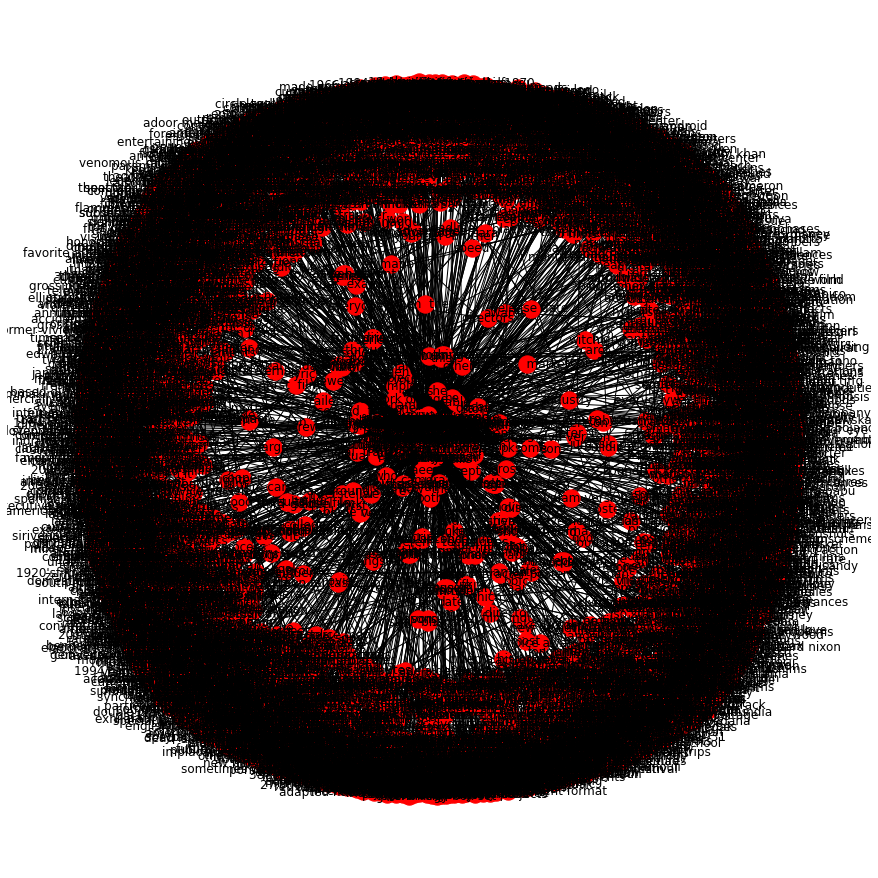

In [121]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

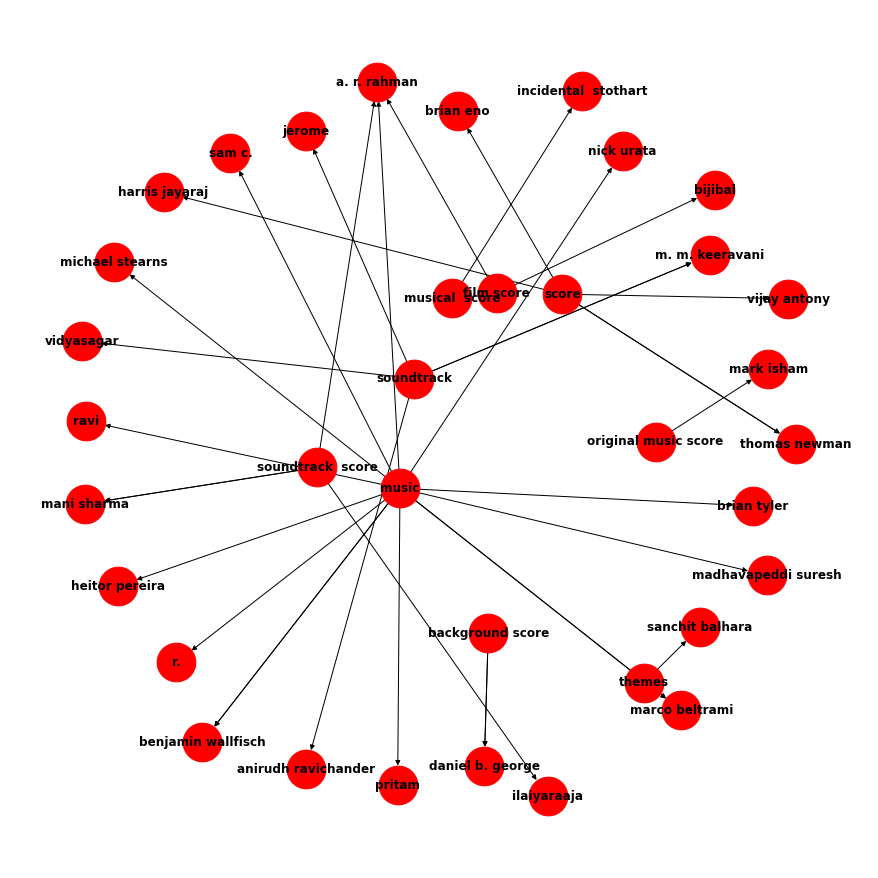

In [122]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()